In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [2]:
# Implement from scratch the following normalization schemes. They should
# be implemented as a sub-class of torch.nn.Module.

# (a) Batch Normalization (BN) [3]
# (b) Instance Normalization (IN) [7]
# (c) Batch-Instance Normalization (BIN) [4]
# (d) Layer Normalization (LN) [1]
# (e) Group Normalization (GN) [8]

import torch
import torch.nn as nn

class NoNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(NoNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return x

class BatchNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        # shape = (1, num_features, 1, 1)
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class InstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(InstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

  

class BatchInstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchInstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        mean = x.mean(dim=[2, 3], keepdim=True)
        variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

    

class LayerNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(LayerNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class GroupNormalise(nn.Module):
    def __init__(self, num_features, num_groups=4, eps=1e-5, momentum=0.1):
        super(GroupNormalise, self).__init__()
        self.num_features = num_features
        self.num_groups = num_groups
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.num_groups, int(C / self.num_groups), H, W)
        mean = x.mean(dim=[1, 2, 3], keepdim=True)
        variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = x.view(N, C, H, W)
        x = self.gamma * x + self.beta
        return x


In [3]:
def norms(dimension, norm_type):
    if norm_type == 'none':
        return NoNormalise(dimension)
    elif norm_type == 'batch':
        return BatchNormalise(dimension)
    elif norm_type == 'instance':
        return InstanceNormalise(dimension)
    elif norm_type == 'batchinstance':
        return BatchInstanceNormalise(dimension)
    elif norm_type == 'layer':
        return LayerNormalise(dimension)
    elif norm_type == 'group':
        return GroupNormalise(dimension)
    else:
        raise ValueError('Invalid norm type')
    

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1, norm_type= 'none'):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = norms(out_chs, norm_type)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = norms(out_chs, norm_type)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    

class resnet(nn.Module): # n layers of blocks, r classes
    def __init__(self, resd_block, layers, img_chs, r, norm_type):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = norms(16, norm_type)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1, norm_type)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2, norm_type)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2, norm_type)
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride, norm_type):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), norms(out_chs, norm_type))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride, norm_type))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs, norm_type=norm_type))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

def final_resnet(img_chs, r, n, norm_type):
    return resnet(resd_block, [n, n, n], img_chs, r, norm_type)

In [4]:
# def test():
#     net = final_resnet(3, 25, 2, 'layer')
#     x = torch.randn(2, 3, 256, 256)
#     y = net(x)

# test()

In [5]:
# The hyperparameters

n = 2
r = 25
batch_size = 32
# learning_rate = 0.0001
num_epochs = 50 
num_workers = 4
norm_type = 'batch'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Device: ", device)

Device:  cuda:0


Train Data:  29417
Validation Data:  8413
------------------------Training Started------------------------


100%|██████████| 263/263 [00:19<00:00, 13.36it/s]


Epoch:  0 Train Loss:  0.08668798145221959 Train Accuracy:  19.152190910018017 Train F1 Macro:  0.17397725757756682 Train F1 Micro:  0.19152190910018016
Epoch:  0 Validation Loss:  0.08110938508063112 Validation Accuracy:  23.891596338999168 Validation F1 Macro:  0.21786764470457082 Validation F1 Micro:  0.2389159633899917
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.56it/s]


Epoch:  1 Train Loss:  0.0767961054788098 Train Accuracy:  26.95380222320427 Train F1 Macro:  0.25769854028200734 Train F1 Micro:  0.2695380222320427
Epoch:  1 Validation Loss:  0.07536023175774496 Validation Accuracy:  28.420301913704982 Validation F1 Macro:  0.2713786415331147 Validation F1 Micro:  0.2842030191370498
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.48it/s]


Epoch:  2 Train Loss:  0.07219594156782215 Train Accuracy:  30.61155114389639 Train F1 Macro:  0.29526186679068017 Train F1 Micro:  0.30611551143896387
Epoch:  2 Validation Loss:  0.07169622658237923 Validation Accuracy:  32.02187091406157 Validation F1 Macro:  0.30963803928740524 Validation F1 Micro:  0.32021870914061573
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.49it/s]


Epoch:  3 Train Loss:  0.06861910662936513 Train Accuracy:  33.60641805758575 Train F1 Macro:  0.3260932314784533 Train F1 Micro:  0.3360641805758575
Epoch:  3 Validation Loss:  0.06703111322119108 Validation Accuracy:  35.78984904314751 Validation F1 Macro:  0.34445269383269617 Validation F1 Micro:  0.3578984904314751
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.43it/s]


Epoch:  4 Train Loss:  0.06586385147695648 Train Accuracy:  36.10157391984227 Train F1 Macro:  0.3524825647019311 Train F1 Micro:  0.36101573919842267
Epoch:  4 Validation Loss:  0.06364852772390434 Validation Accuracy:  37.917508617615596 Validation F1 Macro:  0.3706157768365868 Validation F1 Micro:  0.379175086176156
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.37it/s]


Epoch:  5 Train Loss:  0.06360247616829966 Train Accuracy:  37.85226229731108 Train F1 Macro:  0.370186670293285 Train F1 Micro:  0.3785226229731108
Epoch:  5 Validation Loss:  0.06300231799860566 Validation Accuracy:  37.489599429454415 Validation F1 Macro:  0.3715913830107212 Validation F1 Micro:  0.3748959942945442
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.34it/s]


Epoch:  6 Train Loss:  0.06135501559101539 Train Accuracy:  40.38141210864466 Train F1 Macro:  0.39711521998529425 Train F1 Micro:  0.4038141210864466
Epoch:  6 Validation Loss:  0.059062367845598984 Validation Accuracy:  42.446214192321406 Validation F1 Macro:  0.41785588584150873 Validation F1 Micro:  0.4244621419232141
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.47it/s]


Epoch:  7 Train Loss:  0.05957111820113056 Train Accuracy:  41.97232892545127 Train F1 Macro:  0.4129014809200236 Train F1 Micro:  0.4197232892545127
Epoch:  7 Validation Loss:  0.0571404052421169 Validation Accuracy:  44.70462379650541 Validation F1 Macro:  0.4363366838966394 Validation F1 Micro:  0.4470462379650541
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.35it/s]


Epoch:  8 Train Loss:  0.05792828610708725 Train Accuracy:  43.994968895536594 Train F1 Macro:  0.434067369158572 Train F1 Micro:  0.43994968895536596
Epoch:  8 Validation Loss:  0.057246633903968634 Validation Accuracy:  44.52632830143825 Validation F1 Macro:  0.43816818201069324 Validation F1 Micro:  0.4452632830143825
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.36it/s]


Epoch:  9 Train Loss:  0.056380716074322296 Train Accuracy:  45.34452867389604 Train F1 Macro:  0.44761786695777384 Train F1 Micro:  0.45344528673896045
Epoch:  9 Validation Loss:  0.05682838247205788 Validation Accuracy:  44.252941875668604 Validation F1 Macro:  0.43682889061355273 Validation F1 Micro:  0.44252941875668605
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.23it/s]


Epoch:  10 Train Loss:  0.05489600837791939 Train Accuracy:  46.724683006424854 Train F1 Macro:  0.4624989594441842 Train F1 Micro:  0.46724683006424855
Epoch:  10 Validation Loss:  0.05347259525990325 Validation Accuracy:  47.854510876025195 Validation F1 Macro:  0.4761186049424923 Validation F1 Micro:  0.47854510876025197
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.31it/s]


Epoch:  11 Train Loss:  0.0535391323846133 Train Accuracy:  48.013053676445594 Train F1 Macro:  0.4759786470199188 Train F1 Micro:  0.48013053676445594
Epoch:  11 Validation Loss:  0.05202581375061537 Validation Accuracy:  49.8870795197908 Validation F1 Macro:  0.4953470970949678 Validation F1 Micro:  0.498870795197908
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.35it/s]


Epoch:  12 Train Loss:  0.05215306154717221 Train Accuracy:  49.603970493252206 Train F1 Macro:  0.49246606031637863 Train F1 Micro:  0.49603970493252203
Epoch:  12 Validation Loss:  0.050605224901326525 Validation Accuracy:  51.47985260905741 Validation F1 Macro:  0.515128721368421 Validation F1 Micro:  0.5147985260905741
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.30it/s]


Epoch:  13 Train Loss:  0.05127015196337319 Train Accuracy:  50.59999320121018 Train F1 Macro:  0.502760557693172 Train F1 Micro:  0.5059999320121018
Epoch:  13 Validation Loss:  0.049463801423363804 Validation Accuracy:  52.46642101509569 Validation F1 Macro:  0.5208703817720169 Validation F1 Micro:  0.5246642101509569
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.31it/s]


Epoch:  14 Train Loss:  0.04988766914035315 Train Accuracy:  52.24530033654009 Train F1 Macro:  0.520001639819139 Train F1 Micro:  0.5224530033654009
Epoch:  14 Validation Loss:  0.04848673776753887 Validation Accuracy:  52.78735290621657 Validation F1 Macro:  0.52004169687704 Validation F1 Micro:  0.5278735290621657
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.25it/s]


Epoch:  15 Train Loss:  0.048922967573607375 Train Accuracy:  53.064554509297345 Train F1 Macro:  0.5275501959593207 Train F1 Micro:  0.5306455450929735
Epoch:  15 Validation Loss:  0.04637578822664397 Validation Accuracy:  54.712944252941874 Validation F1 Macro:  0.5411918067600962 Validation F1 Micro:  0.5471294425294188
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.19it/s]


Epoch:  16 Train Loss:  0.047875441271171826 Train Accuracy:  54.077574191793865 Train F1 Macro:  0.5383151871219063 Train F1 Micro:  0.5407757419179386
Epoch:  16 Validation Loss:  0.04618284901880586 Validation Accuracy:  54.98633067871152 Validation F1 Macro:  0.5433908232033474 Validation F1 Micro:  0.5498633067871151
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.23it/s]


Epoch:  17 Train Loss:  0.046955554501206434 Train Accuracy:  55.00900839650542 Train F1 Macro:  0.548220555436123 Train F1 Micro:  0.5500900839650542
Epoch:  17 Validation Loss:  0.04589435210922846 Validation Accuracy:  54.938785213360276 Validation F1 Macro:  0.5422784204208906 Validation F1 Micro:  0.5493878521336027
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.14it/s]


Epoch:  18 Train Loss:  0.04615459740557004 Train Accuracy:  55.48492368358432 Train F1 Macro:  0.5528560038957016 Train F1 Micro:  0.5548492368358432
Epoch:  18 Validation Loss:  0.04339794873922061 Validation Accuracy:  58.63544514441935 Validation F1 Macro:  0.5841792047179762 Validation F1 Micro:  0.5863544514441935
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.17it/s]


Epoch:  19 Train Loss:  0.0451762759535983 Train Accuracy:  56.504742155896245 Train F1 Macro:  0.5635324332010246 Train F1 Micro:  0.5650474215589625
Epoch:  19 Validation Loss:  0.04397632231415345 Validation Accuracy:  58.39771781766314 Validation F1 Macro:  0.581341914688709 Validation F1 Micro:  0.5839771781766314
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.20it/s]


Epoch:  20 Train Loss:  0.04431745756951796 Train Accuracy:  57.78631403610157 Train F1 Macro:  0.5760778780619417 Train F1 Micro:  0.5778631403610157
Epoch:  20 Validation Loss:  0.041721000245446956 Validation Accuracy:  60.87008201592773 Validation F1 Macro:  0.6080896876883931 Validation F1 Micro:  0.6087008201592773
---------------------------------------------------------------


100%|██████████| 263/263 [00:19<00:00, 13.21it/s]


Epoch:  21 Train Loss:  0.04341784565673345 Train Accuracy:  58.778937349151846 Train F1 Macro:  0.5865326427832812 Train F1 Micro:  0.5877893734915185
Epoch:  21 Validation Loss:  0.04070099035199808 Validation Accuracy:  61.11969570902175 Validation F1 Macro:  0.6083847573395819 Validation F1 Micro:  0.6111969570902175
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.05it/s]


Epoch:  22 Train Loss:  0.042644396172538505 Train Accuracy:  59.540401808478094 Train F1 Macro:  0.5942565908381601 Train F1 Micro:  0.5954040180847809
Epoch:  22 Validation Loss:  0.041683771423787375 Validation Accuracy:  59.87162724355165 Validation F1 Macro:  0.5988631612756804 Validation F1 Micro:  0.5987162724355165
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.13it/s]


Epoch:  23 Train Loss:  0.04209300743859626 Train Accuracy:  60.02991467518781 Train F1 Macro:  0.5995545659993705 Train F1 Micro:  0.6002991467518781
Epoch:  23 Validation Loss:  0.03978344277884693 Validation Accuracy:  62.676809699274926 Validation F1 Macro:  0.6242318215515107 Validation F1 Micro:  0.6267680969927493
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.10it/s]


Epoch:  24 Train Loss:  0.04137602140785386 Train Accuracy:  61.053132542407454 Train F1 Macro:  0.6096371513071683 Train F1 Micro:  0.6105313254240745
Epoch:  24 Validation Loss:  0.04047004464589981 Validation Accuracy:  62.15380958041127 Validation F1 Macro:  0.622090384803894 Validation F1 Micro:  0.6215380958041127
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.09it/s]


Epoch:  25 Train Loss:  0.04092244986111276 Train Accuracy:  61.42706598225516 Train F1 Macro:  0.613584315724693 Train F1 Micro:  0.6142706598225516
Epoch:  25 Validation Loss:  0.038038045699284956 Validation Accuracy:  63.556400808272905 Validation F1 Macro:  0.6355469981516211 Validation F1 Micro:  0.6355640080827291
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.12it/s]


Epoch:  26 Train Loss:  0.04009252057610579 Train Accuracy:  62.33130502770506 Train F1 Macro:  0.6227762792037863 Train F1 Micro:  0.6233130502770506
Epoch:  26 Validation Loss:  0.03841757271507471 Validation Accuracy:  64.57862831332461 Validation F1 Macro:  0.6473954110271828 Validation F1 Micro:  0.6457862831332462
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.98it/s]


Epoch:  27 Train Loss:  0.039388480197241775 Train Accuracy:  62.58286025087535 Train F1 Macro:  0.6253288639664899 Train F1 Micro:  0.6258286025087535
Epoch:  27 Validation Loss:  0.03654460715940077 Validation Accuracy:  66.08819683822655 Validation F1 Macro:  0.6604759516025829 Validation F1 Micro:  0.6608819683822655
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.07it/s]


Epoch:  28 Train Loss:  0.03887760392399848 Train Accuracy:  63.69786178060305 Train F1 Macro:  0.6368186677624778 Train F1 Micro:  0.6369786178060305
Epoch:  28 Validation Loss:  0.03646275325662016 Validation Accuracy:  65.74349221443005 Validation F1 Macro:  0.65940543276072 Validation F1 Micro:  0.6574349221443004
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.11it/s]


Epoch:  29 Train Loss:  0.03829910923372367 Train Accuracy:  64.10578916952782 Train F1 Macro:  0.640776856006012 Train F1 Micro:  0.6410578916952783
Epoch:  29 Validation Loss:  0.03665590083274606 Validation Accuracy:  65.1254011648639 Validation F1 Macro:  0.6502849986592936 Validation F1 Micro:  0.651254011648639
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.06it/s]


Epoch:  30 Train Loss:  0.03778011127295823 Train Accuracy:  64.93524152700819 Train F1 Macro:  0.6492696987191868 Train F1 Micro:  0.6493524152700819
Epoch:  30 Validation Loss:  0.03635525565984543 Validation Accuracy:  66.07631047188875 Validation F1 Macro:  0.6623963620551421 Validation F1 Micro:  0.6607631047188874
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.99it/s]


Epoch:  31 Train Loss:  0.03734290234499632 Train Accuracy:  65.34656831084067 Train F1 Macro:  0.6533537594937073 Train F1 Micro:  0.6534656831084067
Epoch:  31 Validation Loss:  0.03608182159428589 Validation Accuracy:  66.24271960061809 Validation F1 Macro:  0.6629411313297137 Validation F1 Micro:  0.6624271960061809
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.95it/s]


Epoch:  32 Train Loss:  0.03695697106377177 Train Accuracy:  65.30917496685589 Train F1 Macro:  0.6527575336976708 Train F1 Micro:  0.653091749668559
Epoch:  32 Validation Loss:  0.03475431592409469 Validation Accuracy:  68.02567455128967 Validation F1 Macro:  0.677612960615046 Validation F1 Micro:  0.6802567455128967
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.97it/s]


Epoch:  33 Train Loss:  0.03651887495723511 Train Accuracy:  65.93466362987388 Train F1 Macro:  0.6592225384610289 Train F1 Micro:  0.6593466362987388
Epoch:  33 Validation Loss:  0.034724786521619616 Validation Accuracy:  67.1579698086295 Validation F1 Macro:  0.667804847932497 Validation F1 Micro:  0.671579698086295
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.96it/s]


Epoch:  34 Train Loss:  0.03601974875183681 Train Accuracy:  66.70972566883094 Train F1 Macro:  0.6670644238832041 Train F1 Micro:  0.6670972566883094
Epoch:  34 Validation Loss:  0.03353136620948902 Validation Accuracy:  69.14299298704385 Validation F1 Macro:  0.6912435796476883 Validation F1 Micro:  0.6914299298704386
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.97it/s]


Epoch:  35 Train Loss:  0.03570950792320208 Train Accuracy:  66.7947105415236 Train F1 Macro:  0.6680602921669722 Train F1 Micro:  0.667947105415236
Epoch:  35 Validation Loss:  0.03331201055501058 Validation Accuracy:  69.5352430761916 Validation F1 Macro:  0.6951063369154749 Validation F1 Micro:  0.6953524307619161
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 13.01it/s]


Epoch:  36 Train Loss:  0.035515778297821515 Train Accuracy:  67.20263793044839 Train F1 Macro:  0.6722221664468833 Train F1 Micro:  0.6720263793044838
Epoch:  36 Validation Loss:  0.03357472625942643 Validation Accuracy:  69.09544752169262 Validation F1 Macro:  0.6913841024382472 Validation F1 Micro:  0.6909544752169262
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.83it/s]


Epoch:  37 Train Loss:  0.03509886997798146 Train Accuracy:  67.72274535132746 Train F1 Macro:  0.6771105991278767 Train F1 Micro:  0.6772274535132746
Epoch:  37 Validation Loss:  0.03272747715744042 Validation Accuracy:  69.89183406632591 Validation F1 Macro:  0.6994615007454398 Validation F1 Micro:  0.6989183406632592
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  38 Train Loss:  0.03468460385381282 Train Accuracy:  68.19526124349866 Train F1 Macro:  0.6822936304488435 Train F1 Micro:  0.6819526124349866
Epoch:  38 Validation Loss:  0.032669692723246345 Validation Accuracy:  69.95126589801498 Validation F1 Macro:  0.7003842306718571 Validation F1 Micro:  0.6995126589801498
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.88it/s]


Epoch:  39 Train Loss:  0.034595813132257965 Train Accuracy:  68.1136757657137 Train F1 Macro:  0.6812726885882151 Train F1 Micro:  0.681136757657137
Epoch:  39 Validation Loss:  0.03248811767087968 Validation Accuracy:  70.62878877927018 Validation F1 Macro:  0.705168191072525 Validation F1 Micro:  0.7062878877927018
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  40 Train Loss:  0.03427882953654108 Train Accuracy:  68.62018560696195 Train F1 Macro:  0.6863734316837398 Train F1 Micro:  0.6862018560696196
Epoch:  40 Validation Loss:  0.03181549349863294 Validation Accuracy:  71.28253892784976 Validation F1 Macro:  0.7138754682240933 Validation F1 Micro:  0.7128253892784976
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.87it/s]


Epoch:  41 Train Loss:  0.03403074529544864 Train Accuracy:  68.9533263079172 Train F1 Macro:  0.6897675914803528 Train F1 Micro:  0.689533263079172
Epoch:  41 Validation Loss:  0.03174251472781363 Validation Accuracy:  71.49649352193035 Validation F1 Macro:  0.7143637486671628 Validation F1 Micro:  0.7149649352193035
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.83it/s]


Epoch:  42 Train Loss:  0.03369350773061842 Train Accuracy:  69.21507971581059 Train F1 Macro:  0.6924424158250433 Train F1 Micro:  0.6921507971581059
Epoch:  42 Validation Loss:  0.03245564251978729 Validation Accuracy:  70.9972661357423 Validation F1 Macro:  0.7117240336152569 Validation F1 Micro:  0.709972661357423
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.95it/s]


Epoch:  43 Train Loss:  0.03365375221263918 Train Accuracy:  69.05190876024068 Train F1 Macro:  0.6908269477640876 Train F1 Micro:  0.6905190876024068
Epoch:  43 Validation Loss:  0.03149877174046835 Validation Accuracy:  70.73576607631047 Validation F1 Macro:  0.7072738188964276 Validation F1 Micro:  0.7073576607631046
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  44 Train Loss:  0.03341047932282503 Train Accuracy:  69.63660468436619 Train F1 Macro:  0.6962477841247038 Train F1 Micro:  0.6963660468436619
Epoch:  44 Validation Loss:  0.031198007592077446 Validation Accuracy:  71.87685724474028 Validation F1 Macro:  0.7199679497539568 Validation F1 Micro:  0.7187685724474028
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  45 Train Loss:  0.03330431505391862 Train Accuracy:  69.69439439779718 Train F1 Macro:  0.6974824812955344 Train F1 Micro:  0.6969439439779719
Epoch:  45 Validation Loss:  0.030892456722404052 Validation Accuracy:  72.25722096755021 Validation F1 Macro:  0.7225265903844152 Validation F1 Micro:  0.7225722096755022
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  46 Train Loss:  0.033059660914550724 Train Accuracy:  69.77597987558215 Train F1 Macro:  0.6980077648045717 Train F1 Micro:  0.6977597987558215
Epoch:  46 Validation Loss:  0.03059940098029998 Validation Accuracy:  72.49494829430643 Validation F1 Macro:  0.7262704845504796 Validation F1 Micro:  0.7249494829430643
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.80it/s]


Epoch:  47 Train Loss:  0.033059497370038944 Train Accuracy:  69.86776353809022 Train F1 Macro:  0.6991911904856835 Train F1 Micro:  0.6986776353809022
Epoch:  47 Validation Loss:  0.030719055903662147 Validation Accuracy:  71.85308451206465 Validation F1 Macro:  0.7194223281351182 Validation F1 Micro:  0.7185308451206466
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.81it/s]


Epoch:  48 Train Loss:  0.03273448461208466 Train Accuracy:  70.12611755107591 Train F1 Macro:  0.7017343245800136 Train F1 Micro:  0.7012611755107591
Epoch:  48 Validation Loss:  0.030710347073831697 Validation Accuracy:  72.05515273980744 Validation F1 Macro:  0.7213582487144556 Validation F1 Micro:  0.7205515273980744
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  49 Train Loss:  0.03272986508394019 Train Accuracy:  70.20430363395316 Train F1 Macro:  0.7024763022157973 Train F1 Micro:  0.7020430363395316
Epoch:  49 Validation Loss:  0.030666985539623152 Validation Accuracy:  72.29288006656364 Validation F1 Macro:  0.7244354675832284 Validation F1 Micro:  0.7229288006656365
---------------------------------------------------------------


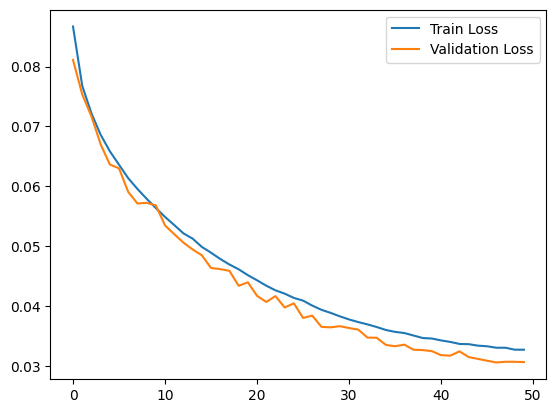

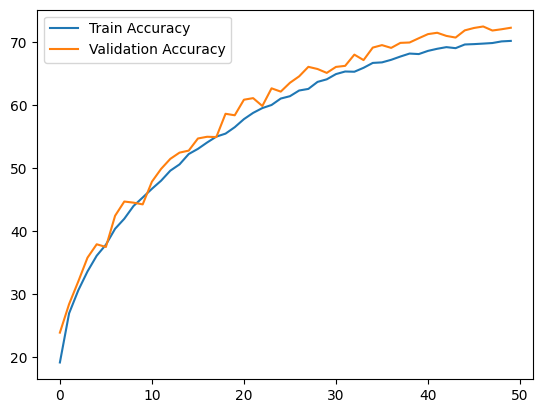

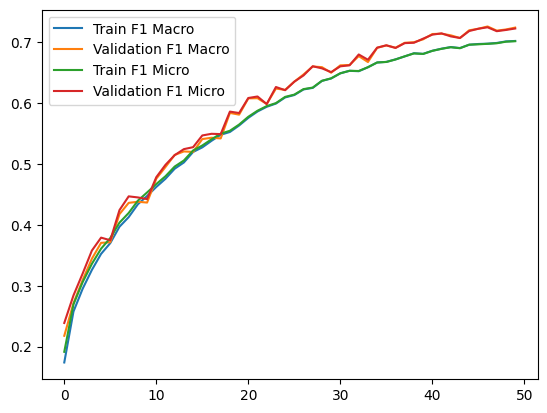

In [6]:
def training():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print("Train Data: ", len(train_dataset))
    print("Validation Data: ", len(val_dataset))

    net = final_resnet(3, r, n, norm_type)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_f1_macro = []
    val_f1_macro = []
    train_f1_micro = []
    val_f1_micro = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)
        train_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        train_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_loss.append(running_loss/total)
        val_accuracy.append((correct/total)*100)
        val_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        val_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Train Accuracy: ", train_accuracy[-1], "Train F1 Macro: ", train_f1_macro[-1], "Train F1 Micro: ", train_f1_micro[-1])

        print("Epoch: ", epoch, "Validation Loss: ", val_loss[-1], "Validation Accuracy: ", val_accuracy[-1], "Validation F1 Macro: ", val_f1_macro[-1], "Validation F1 Micro: ", val_f1_micro[-1])

        print("---------------------------------------------------------------")

        with open('Part2-custom_batchnorm', 'a') as f:
            f.write("Epoch: " + str(epoch) + " Train Loss: " + str(train_loss[-1]) + " Train Accuracy: " + str(train_accuracy[-1]) + " Train F1 Macro: " + str(train_f1_macro[-1]) + " Train F1 Micro: " + str(train_f1_micro[-1]) + "\n")
            f.write("Epoch: " + str(epoch) + " Validation Loss: " + str(val_loss[-1]) + " Validation Accuracy: " + str(val_accuracy[-1]) + " Validation F1 Macro: " + str(val_f1_macro[-1]) + " Validation F1 Micro: " + str(val_f1_micro[-1]) + "\n")
            f.write("---------------------------------------------------------------\n")

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_f1_macro, label='Train F1 Macro')
    plt.plot(val_f1_macro, label='Validation F1 Macro')
    plt.legend()

    plt.plot(train_f1_micro, label='Train F1 Micro')
    plt.plot(val_f1_micro, label='Validation F1 Micro')
    plt.legend()
    plt.show()

    torch.save(net.state_dict(), 'Part2-custom_batchnorm.pth')
    
    
training()